##Cell 1: Import Libraries and Set Random Seeds

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error,
    max_error
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import random
import pandas as pd
import seaborn as sns

# Set random seeds for reproducibility
def seed_everything(seed=4):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

# Check Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cpu


Cell 2: Define Symbolic Functions

In [59]:
# Define multiple symbolic functions
def symbolic_function_1(x):
    return np.sin(5 * x) * np.exp(-x**2)

def symbolic_function_2(x):
    return np.where(x < 0, np.sin(5 * x), np.cos(5 * x)) * np.exp(-x**2)

def symbolic_function_3(x):
    return np.abs(np.sin(5 * x)) * np.exp(-x**2)

def symbolic_function_4(x):
    return np.sin(10 * x) * np.exp(-x**2)

def symbolic_function_5(x):
    return np.sin(15 * x) * np.exp(-x**2)

def symbolic_function_6(x):
    return np.piecewise(x, [x < 0, x >= 0], [lambda x: np.sin(5 * x), lambda x: np.sin(5 * x) + 1]) * np.exp(-x**2)

# Additional Function Classes

# Polynomial Functions
def polynomial_function_1(x):
    # f(x) = x^2
    return x**2

def polynomial_function_2(x):
    # f(x) = x^3 - 2x + 1
    return x**3 - 2*x + 1

# Exponential Functions
def exponential_function_1(x):
    # f(x) = e^x
    return np.exp(x)

def exponential_function_2(x):
    # f(x) = 2e^(0.5x)
    return 2 * np.exp(0.5 * x)

# Logarithmic Functions
def logarithmic_function_1(x):
    # f(x) = ln(|x| + 1)
    return np.log(np.abs(x) + 1)

def logarithmic_function_2(x):
    # f(x) = log10(|x| + 1)
    return np.log10(np.abs(x) + 1)

# Extended Trigonometric Functions
def trigonometric_function_3(x):
    # f(x) = tan(x) * exp(-x^2)
    return np.tan(x) * np.exp(-x**2)

def trigonometric_function_4(x):
    # f(x) = cot(x) * exp(-x^2)
    return (1 / np.tan(x)) * np.exp(-x**2)

# Step Functions
def step_function_1(x):
    # Heaviside function: f(x) = 0 dla x < 0, 1 dla x >= 0
    return np.where(x < 0, 0, 1)

def step_function_2(x):
    # Step function z przesunięciem: f(x) = 0 dla x < -1, 1 dla x >= -1
    return np.where(x < -1, 0, 1)

# Uniform Functions
def uniform_function_1(x):
    # f(x) = 5
    return 5 * np.ones_like(x)

def uniform_function_2(x):
    # f(x) = 3x + 2 + losowy szum
    return 3 * x + 2 + np.random.uniform(-0.5, 0.5, size=x.shape)

# Dictionary of functions for easy access
functions = {
    'Function 1': symbolic_function_1,
    'Function 2': symbolic_function_2,
    'Function 3': symbolic_function_3,
    'Function 4': symbolic_function_4,
    'Function 5': symbolic_function_5,
    'Function 6': symbolic_function_6,
    
    # Polynomial Functions
    'Polynomial 1': polynomial_function_1,
    'Polynomial 2': polynomial_function_2,
    
    # Exponential Functions
    'Exponential 1': exponential_function_1,
    'Exponential 2': exponential_function_2,
    
    # Logarithmic Functions
    'Logarithmic 1': logarithmic_function_1,
    'Logarithmic 2': logarithmic_function_2,
    
    # Extended Trigonometric Functions
    'Trigonometric 3': trigonometric_function_3,
    'Trigonometric 4': trigonometric_function_4,
    
    # Step Functions
    'Step 1': step_function_1,
    'Step 2': step_function_2,
    
    # Uniform Functions
    'Uniform 1': uniform_function_1,
    'Uniform 2': uniform_function_2,
}

Cell 3: Data Generation Function

In [60]:
# Data Generation Function with Output Normalization
def generate_data(symbolic_function, n_samples=10000):
    x_values = np.linspace(-2, 2, n_samples)
    np.random.shuffle(x_values)
    y_values = symbolic_function(x_values)

    # Split into train, validation, and test sets
    train_split = int(0.7 * n_samples)
    val_split = int(0.85 * n_samples)

    x_train = x_values[:train_split]
    y_train = y_values[:train_split]

    x_val = x_values[train_split:val_split]
    y_val = y_values[train_split:val_split]

    x_test = x_values[val_split:]
    y_test = y_values[val_split:]

    # Normalize inputs
    x_mean = x_train.mean()
    x_std = x_train.std()
    x_train = (x_train - x_mean) / x_std
    x_val = (x_val - x_mean) / x_std
    x_test = (x_test - x_mean) / x_std

    # Normalize outputs
    y_scaler = MinMaxScaler()
    y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_val = y_scaler.transform(y_val.reshape(-1, 1)).flatten()
    y_test = y_scaler.transform(y_test.reshape(-1, 1)).flatten()

    # Convert to tensors
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)

    x_val_tensor = torch.tensor(x_val, dtype=torch.float32).unsqueeze(1).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)

    x_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(device)

    # Create data loaders
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

    return train_loader, val_loader, test_loader, x_test, y_test, y_scaler

Cell 4: Define the MLP Model

In [61]:
class MLP(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=14, output_dim=1):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

Cell 5: Define the BSpline Activation and KAN Model

In [62]:
class BSplineActivation(nn.Module):
    def __init__(self, num_parameters=20, init_range=(-1, 1)):
        super(BSplineActivation, self).__init__()
        # Initialize control points
        self.control_points = nn.Parameter(torch.linspace(init_range[0], init_range[1], num_parameters))
        # Initialize weights with smaller variance to stabilize training
        self.weights = nn.Parameter(torch.randn(num_parameters) * 0.1)

    def forward(self, x):
        # Apply the B-spline approximation using linear interpolation
        x_clipped = torch.clamp(x, self.control_points[0], self.control_points[-1])
        indices = torch.bucketize(x_clipped, self.control_points)
        indices = torch.clamp(indices, 1, len(self.control_points) - 1)

        x0 = self.control_points[indices - 1]
        x1 = self.control_points[indices]
        y0 = self.weights[indices - 1]
        y1 = self.weights[indices]

        slope = (y1 - y0) / (x1 - x0 + 1e-6)
        output = y0 + slope * (x_clipped - x0)
        return output

# KAN Model Definition with Increased Spline Points and Dropout
class KAN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=10, output_dim=1, num_spline_points=30):
        super(KAN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.act1 = BSplineActivation(num_parameters=num_spline_points)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.act2 = BSplineActivation(num_parameters=num_spline_points)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.act3 = BSplineActivation(num_parameters=num_spline_points)
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

Cell 6: Training and Evaluation Functions

In [63]:
# Training and Evaluation Functions
def train_model(model, optimizer, criterion, train_loader, val_loader, num_epochs=200, patience=50):
    train_losses = []
    val_losses = []
    best_val_loss = np.inf
    patience_counter = 0

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)

    for epoch in tqdm(range(num_epochs), desc='Training'):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        scheduler.step(epoch_val_loss)

        # Early Stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Load the best model
    model.load_state_dict(best_model_state)
    return train_losses, val_losses

def evaluate_model(model, criterion, test_loader, y_scaler):
    model.eval()
    test_loss = 0.0
    preds = []
    trues = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            preds.append(outputs.cpu().numpy())
            trues.append(targets.cpu().numpy())
    test_loss = test_loss / len(test_loader.dataset)
    preds = np.concatenate(preds).flatten()
    trues = np.concatenate(trues).flatten()

    # Inverse transform predictions and true values
    preds = y_scaler.inverse_transform(preds.reshape(-1, 1)).flatten()
    trues = y_scaler.inverse_transform(trues.reshape(-1, 1)).flatten()

    # Calculating additional metrics
    mae = mean_absolute_error(trues, preds)
    r2 = r2_score(trues, preds)
    mape = mean_absolute_percentage_error(trues, preds)
    max_err = max_error(trues, preds)

    return test_loss, mae, r2, mape, max_err, preds, trues

Cell 7: Main Loop to Train and Evaluate Models


Processing Function 1...
MLP model parameter count: 463
KAN model parameter count: 431
Training MLP Model...


Training: 100%|██████████| 200/200 [00:42<00:00,  4.67it/s]


Training KAN Model...


Training:  56%|█████▌    | 111/200 [00:49<00:39,  2.24it/s]

Early stopping triggered.

Results for Function 1:


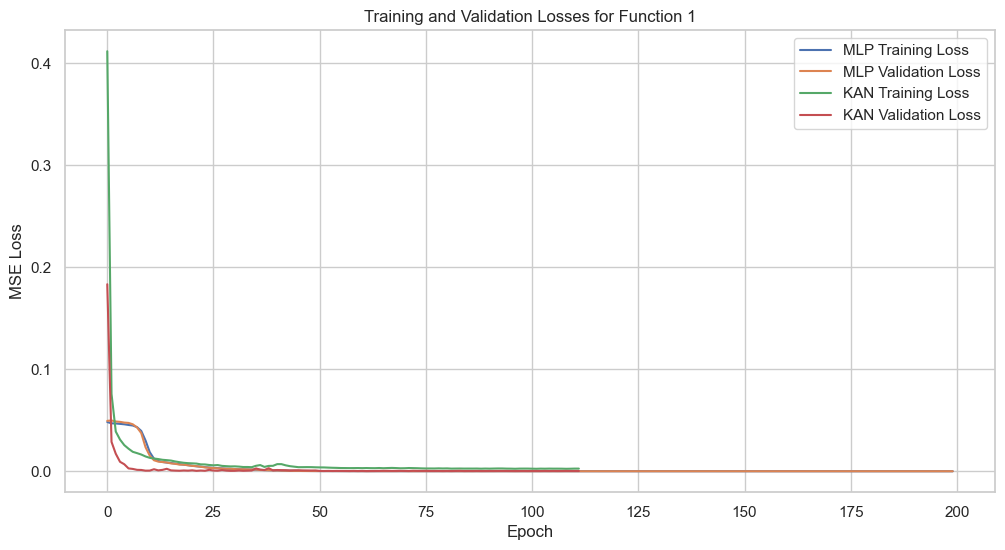

MLP Test MSE Loss: 0.000004
MLP Test MAE: 0.002903
MLP Test R^2 Score: 0.999914
MLP Test MAPE: 0.12%
MLP Test Max Error: 0.014661
KAN Test MSE Loss: 0.000247
KAN Test MAE: 0.020106
KAN Test R^2 Score: 0.994584
KAN Test MAPE: 0.75%
KAN Test Max Error: 0.112668


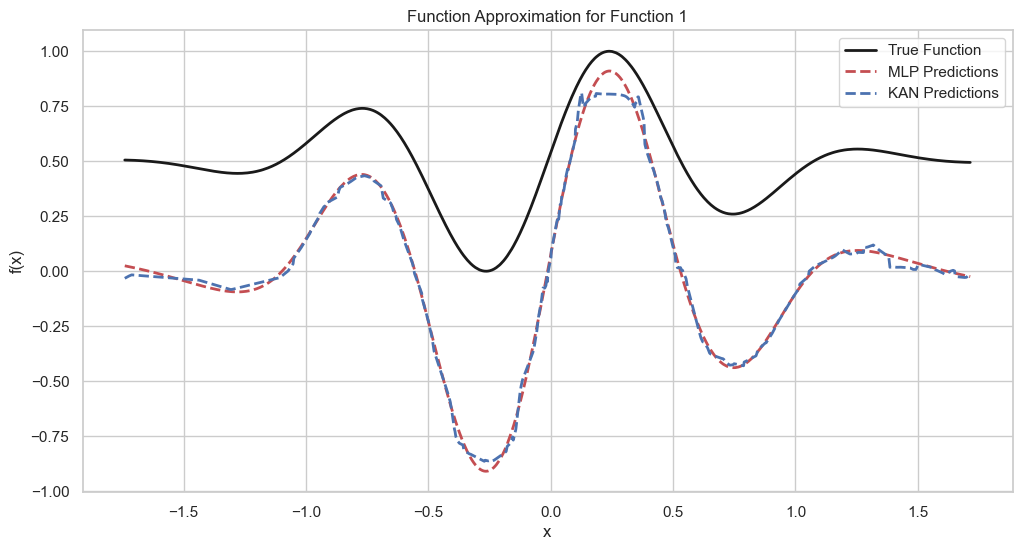

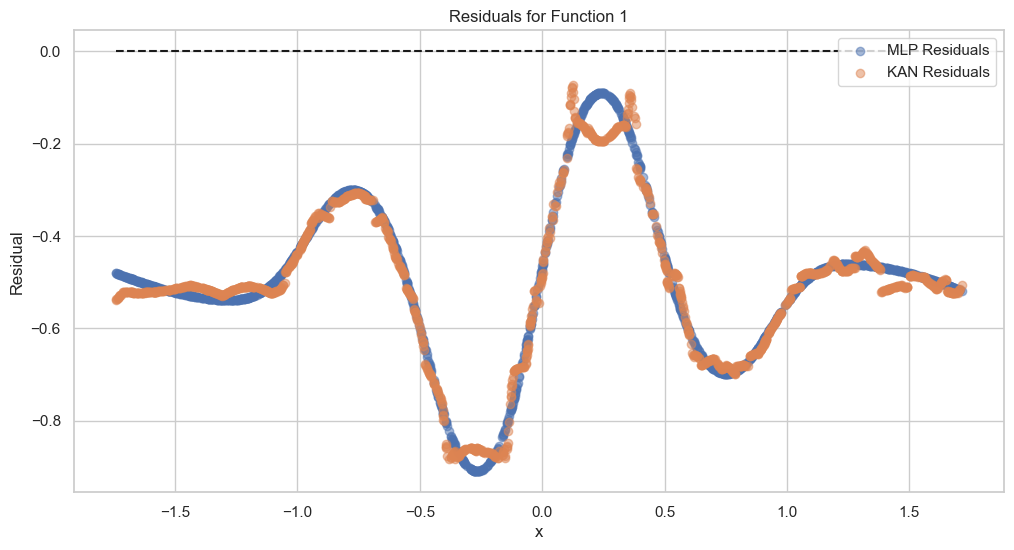

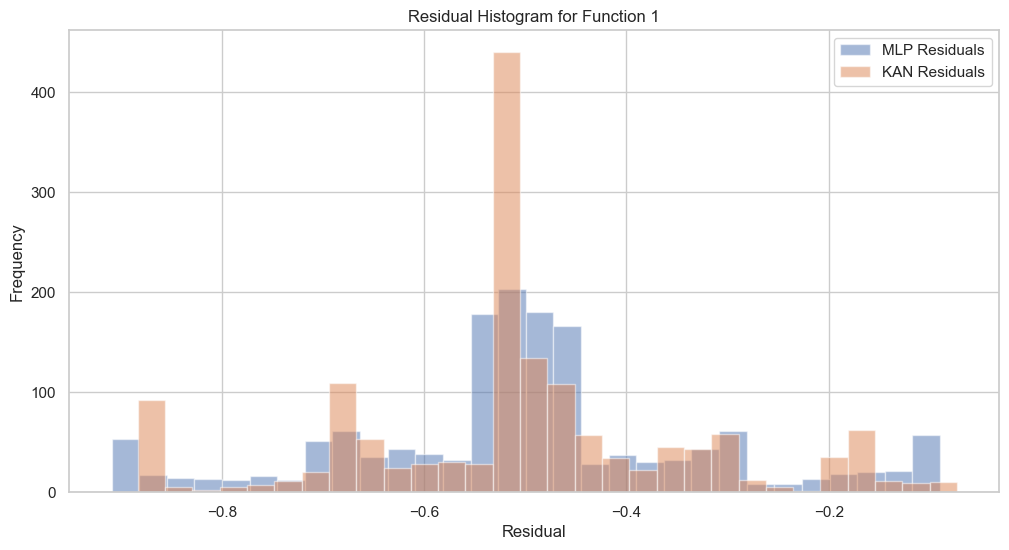


Processing Function 2...
MLP model parameter count: 463
KAN model parameter count: 431
Training MLP Model...


Training: 100%|██████████| 200/200 [00:49<00:00,  4.07it/s]


Training KAN Model...


Training:  80%|████████  | 160/200 [01:10<00:17,  2.27it/s]

Early stopping triggered.

Results for Function 2:


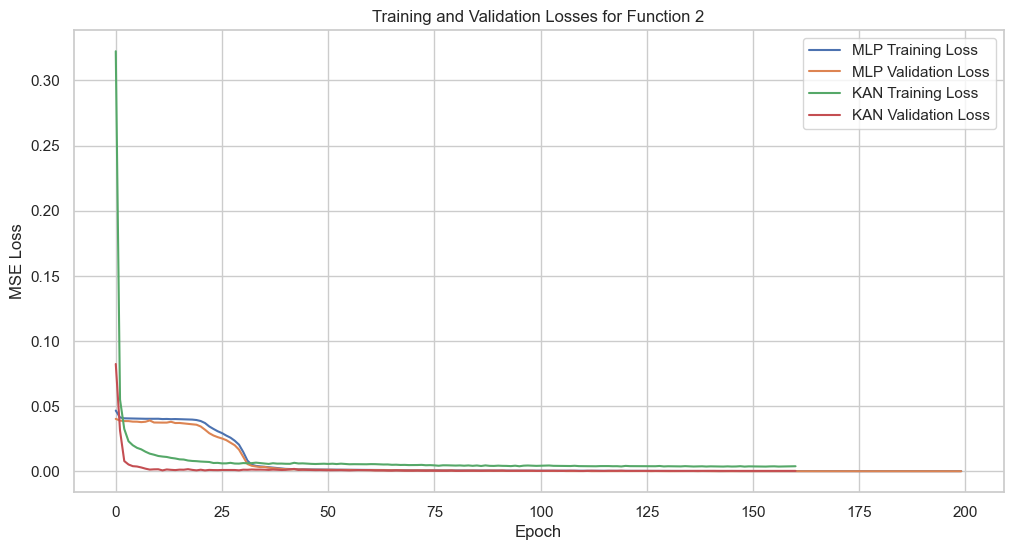

MLP Test MSE Loss: 0.000094
MLP Test MAE: 0.011407
MLP Test R^2 Score: 0.997733
MLP Test MAPE: 0.45%
MLP Test Max Error: 0.335336
KAN Test MSE Loss: 0.000367
KAN Test MAE: 0.025201
KAN Test R^2 Score: 0.991195
KAN Test MAPE: 0.59%
KAN Test Max Error: 0.250430


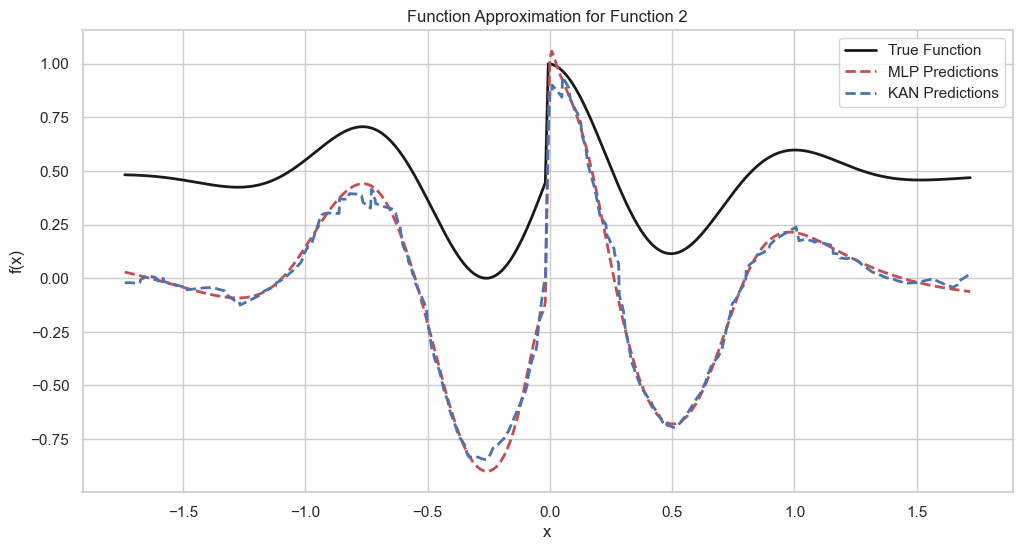

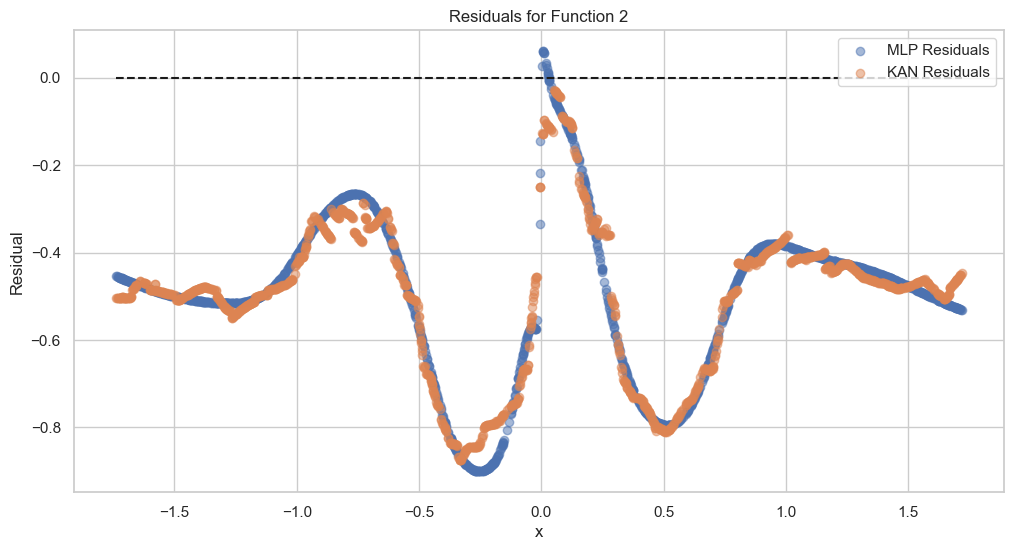

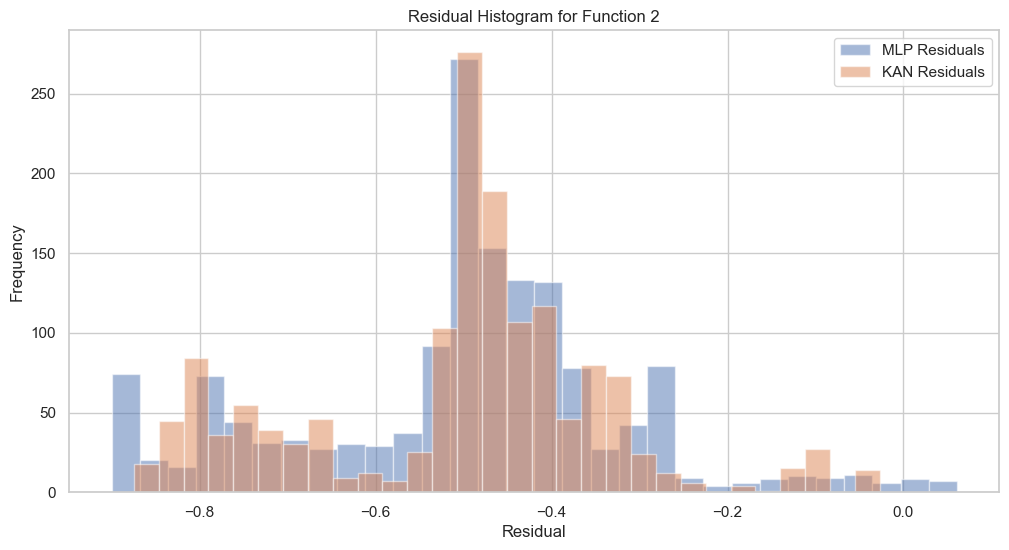


Processing Function 3...
MLP model parameter count: 463
KAN model parameter count: 431
Training MLP Model...


Training: 100%|██████████| 200/200 [00:45<00:00,  4.44it/s]


Training KAN Model...


Training:  82%|████████▏ | 163/200 [01:15<00:17,  2.16it/s]

Early stopping triggered.

Results for Function 3:


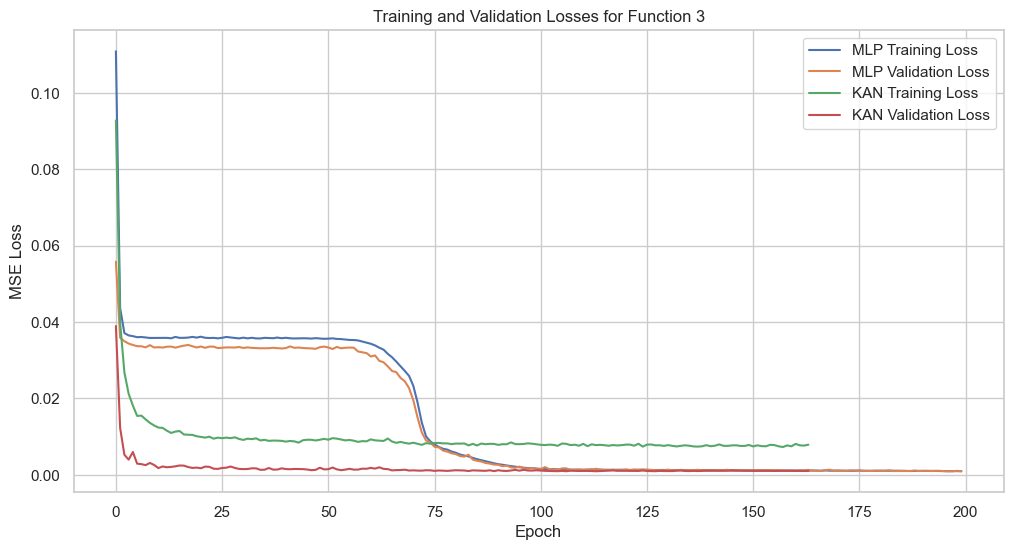

MLP Test MSE Loss: 0.000980
MLP Test MAE: 0.022117
MLP Test R^2 Score: 0.989595
MLP Test MAPE: 4.75%
MLP Test Max Error: 0.087177
KAN Test MSE Loss: 0.001056
KAN Test MAE: 0.023997
KAN Test R^2 Score: 0.988781
KAN Test MAPE: 4.56%
KAN Test Max Error: 0.092529


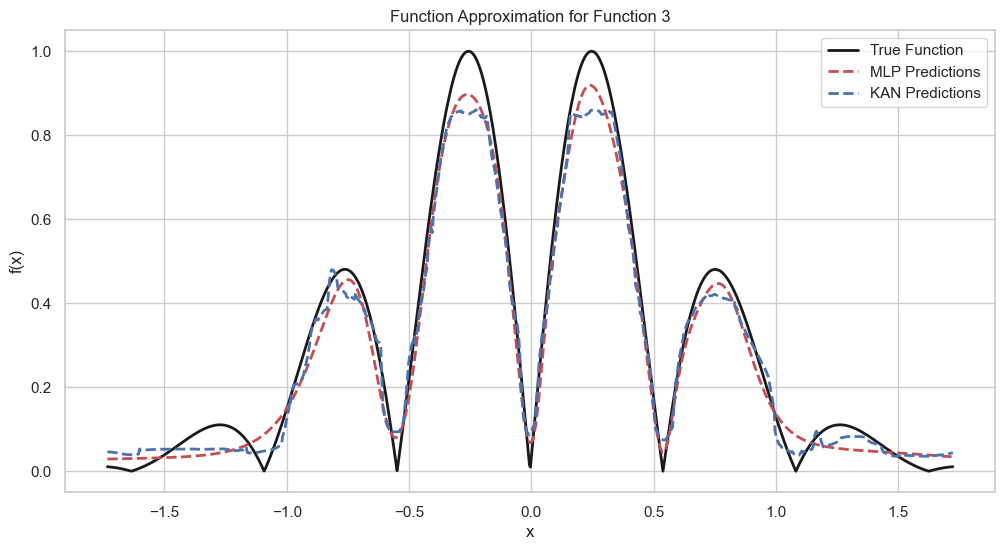

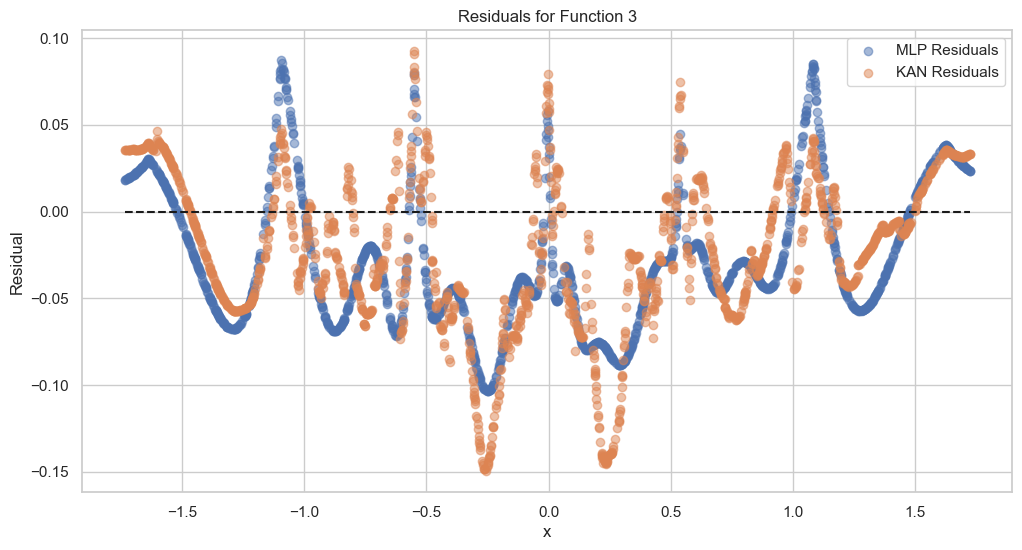

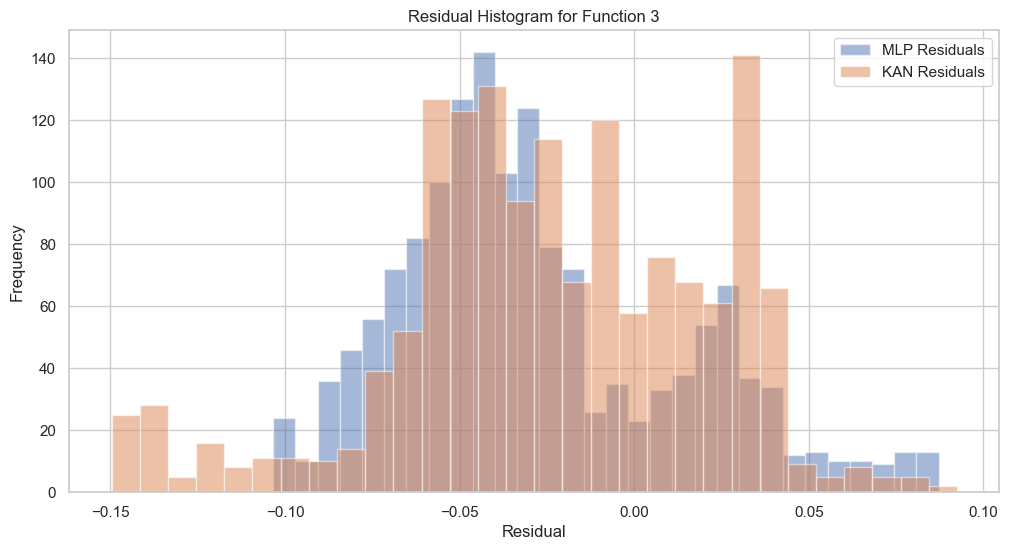


Processing Function 4...
MLP model parameter count: 463
KAN model parameter count: 431
Training MLP Model...


Training:  33%|███▎      | 66/200 [00:15<00:31,  4.20it/s]

In [57]:
# Define criterion
criterion = nn.MSELoss()

# Store results for all functions
results = {}

for func_name, func in functions.items():
    print(f"\nProcessing {func_name}...")

    # Generate data
    train_loader, val_loader, test_loader, x_test, y_test, y_scaler = generate_data(func)

    # Initialize models
    mlp_model = MLP().to(device)
    kan_model = KAN().to(device)

    print("MLP model parameter count:", sum(p.numel() for p in mlp_model.parameters()))
    print("KAN model parameter count:", sum(p.numel() for p in kan_model.parameters()))

    # Optimizers with adjusted learning rates and weight decay
    mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
    kan_optimizer = optim.Adam(kan_model.parameters(), lr=0.001, weight_decay=1e-4)

    # Train MLP Model
    print("Training MLP Model...")
    mlp_train_losses, mlp_val_losses = train_model(
        mlp_model, mlp_optimizer, criterion, train_loader, val_loader
    )
    mlp_test_loss, mlp_mae, mlp_r2, mlp_mape, mlp_max_err, mlp_preds, mlp_trues = evaluate_model(
        mlp_model, criterion, test_loader, y_scaler
    )

    # Train KAN Model
    print("Training KAN Model...")
    kan_train_losses, kan_val_losses = train_model(
        kan_model, kan_optimizer, criterion, train_loader, val_loader
    )
    kan_test_loss, kan_mae, kan_r2, kan_mape, kan_max_err, kan_preds, kan_trues = evaluate_model(
        kan_model, criterion, test_loader, y_scaler
    )

    # Store results
    results[func_name] = {
        'MLP': {
            'train_losses': mlp_train_losses,
            'val_losses': mlp_val_losses,
            'test_loss': mlp_test_loss,
            'mae': mlp_mae,
            'r2': mlp_r2,
            'mape': mlp_mape,
            'max_error': mlp_max_err,
            'preds': mlp_preds,
            'trues': mlp_trues,
        },
        'KAN': {
            'train_losses': kan_train_losses,
            'val_losses': kan_val_losses,
            'test_loss': kan_test_loss,
            'mae': kan_mae,
            'r2': kan_r2,
            'mape': kan_mape,
            'max_error': kan_max_err,
            'preds': kan_preds,
            'trues': kan_trues,
        },
        'x_test': x_test,
        'y_test': y_test,
    }

    # Plotting results
    print(f"\nResults for {func_name}:")

    # Extract data
    mlp_train_losses = results[func_name]['MLP']['train_losses']
    mlp_val_losses = results[func_name]['MLP']['val_losses']
    kan_train_losses = results[func_name]['KAN']['train_losses']
    kan_val_losses = results[func_name]['KAN']['val_losses']

    # Plot Training and Validation Losses
    plt.figure(figsize=(12, 6))
    plt.plot(mlp_train_losses, label='MLP Training Loss')
    plt.plot(mlp_val_losses, label='MLP Validation Loss')
    plt.plot(kan_train_losses, label='KAN Training Loss')
    plt.plot(kan_val_losses, label='KAN Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f'Training and Validation Losses for {func_name}')
    plt.legend()
    plt.show()

    # Test Metrics
    print(f"MLP Test MSE Loss: {results[func_name]['MLP']['test_loss']:.6f}")
    print(f"MLP Test MAE: {results[func_name]['MLP']['mae']:.6f}")
    print(f"MLP Test R^2 Score: {results[func_name]['MLP']['r2']:.6f}")
    print(f"MLP Test MAPE: {results[func_name]['MLP']['mape']:.2f}%")
    print(f"MLP Test Max Error: {results[func_name]['MLP']['max_error']:.6f}")

    print(f"KAN Test MSE Loss: {results[func_name]['KAN']['test_loss']:.6f}")
    print(f"KAN Test MAE: {results[func_name]['KAN']['mae']:.6f}")
    print(f"KAN Test R^2 Score: {results[func_name]['KAN']['r2']:.6f}")
    print(f"KAN Test MAPE: {results[func_name]['KAN']['mape']:.2f}%")
    print(f"KAN Test Max Error: {results[func_name]['KAN']['max_error']:.6f}")

    # Plot Predictions vs True Function
    x_test = results[func_name]['x_test']
    y_test = results[func_name]['y_test']
    mlp_preds = results[func_name]['MLP']['preds']
    kan_preds = results[func_name]['KAN']['preds']

    # Sort for plotting
    sorted_indices = np.argsort(x_test)
    x_test_sorted = x_test[sorted_indices]
    y_test_sorted = y_test[sorted_indices]
    mlp_preds_sorted = mlp_preds[sorted_indices]
    kan_preds_sorted = kan_preds[sorted_indices]

    # Plot Predictions
    plt.figure(figsize=(12, 6))
    plt.plot(x_test_sorted, y_test_sorted, 'k-', label='True Function', linewidth=2)
    plt.plot(x_test_sorted, mlp_preds_sorted, 'r--', label='MLP Predictions', linewidth=2)
    plt.plot(x_test_sorted, kan_preds_sorted, 'b--', label='KAN Predictions', linewidth=2)
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title(f'Function Approximation for {func_name}')
    plt.legend()
    plt.show()

    # Plot Residuals
    plt.figure(figsize=(12, 6))
    plt.scatter(x_test, mlp_preds - y_test, alpha=0.5, label='MLP Residuals')
    plt.scatter(x_test, kan_preds - y_test, alpha=0.5, label='KAN Residuals')
    plt.hlines(0, x_test.min(), x_test.max(), colors='k', linestyles='dashed')
    plt.xlabel('x')
    plt.ylabel('Residual')
    plt.title(f'Residuals for {func_name}')
    plt.legend()
    plt.show()

    # Plot Histograms of Residuals
    plt.figure(figsize=(12,6))
    plt.hist(mlp_preds - y_test, bins=30, alpha=0.5, label='MLP Residuals')
    plt.hist(kan_preds - y_test, bins=30, alpha=0.5, label='KAN Residuals')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.title(f'Residual Histogram for {func_name}')
    plt.legend()
    plt.show()

# Creating Summary Table of Metrics
summary_data = []

for func_name in functions.keys():
    mlp_metrics = results[func_name]['MLP']
    kan_metrics = results[func_name]['KAN']

    summary_data.append({
        'Function': func_name,
        'Model': 'MLP',
        'MSE': mlp_metrics['test_loss'],
        'MAE': mlp_metrics['mae'],
        'R²': mlp_metrics['r2'],
        'MAPE (%)': mlp_metrics['mape'],
        'Max Error': mlp_metrics['max_error']
    })

    summary_data.append({
        'Function': func_name,
        'Model': 'KAN',
        'MSE': kan_metrics['test_loss'],
        'MAE': kan_metrics['mae'],
        'R²': kan_metrics['r2'],
        'MAPE (%)': kan_metrics['mape'],
        'Max Error': kan_metrics['max_error']
    })

# Creating DataFrame
summary_df = pd.DataFrame(summary_data)

# Displaying the table
print("\nSummary of Metrics:")
print(summary_df)

# Optionally, save the table to a CSV file
summary_df.to_csv('model_comparison_summary.csv', index=False)

# Visualizing Metrics with Seaborn
sns.set(style="whitegrid")

metrics = ['MSE', 'MAE', 'R²', 'MAPE (%)', 'Max Error']

for metric in metrics:
    plt.figure(figsize=(14, 7))
    sns.barplot(x='Function', y=metric, hue='Model', data=summary_df)
    plt.title(f'Comparison of {metric} between MLP and KAN')
    plt.xlabel('Function')
    plt.ylabel(metric)
    plt.legend(title='Model')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()